
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>
    Amirabbas Afzali 

____

# Personal Data

In [1]:
# Set your student number
student_number = '99101579'
Name = 'Radin'
Last_Name = 'Khayyam'

# Rules
- Make sure that all of your cells can be run perfectly. 
- Try to minimize your use of ChatGPT (or any other AI assistant) as much as possible.
- You must create a report for this task in PDF format and explain the main results.

---

## **Introduction**

Large Language Models (LLMs) are a class of deep learning models designed for processing and generating natural language. These models are trained using large amounts of textual data and utilize architectures based on transformers. Some of the applications of these models include text generation, machine translation, text summarization, question answering, and text classification.

### *Encoder-Decoder LLMs*

One of the common architectures in large language models is the Encoder-Decoder architecture. In this architecture, the encoder processes an input sequence and maps it to a latent space. Then, the decoder uses this latent space to generate an output sequence. Models like T5 [1] (Text-to-Text Transfer Transformer) use this architecture to perform various tasks. In T5, all tasks are expressed in a "text-to-text" format, meaning both input and output are text. This model has capabilities such as translation, summarization, and text classification. One of the advantages of the Encoder-Decoder architecture is that it allows the encoder to utilize information from both before and after a word to gain a more comprehensive understanding of the text.

### *Decoder-only LLMs*

Decoder-only models, such as GPT-2, GPT-3, and LLaMA [2], unlike the Encoder-Decoder architecture, only use the decoder part. These models use an autoregressive mode, meaning they predict the next token based on previous tokens. These models are highly efficient for text generation and have found widespread applications today.

Advantages of Decoder-only Models

- Efficiency: Decoder-only models are more efficient than Encoder-Decoder models due to the absence of an independent encoder. This makes them require fewer computational and memory resources.
- Simplicity: Due to their autoregressive nature, these models can easily generate sequences in order.
- Scalability: Due to their simpler architecture, these models can be scaled to much larger sizes.


However, one of the drawbacks of these models is that they can only utilize information from tokens before the current token and cannot use tokens that come after for prediction. This limitation is significant in tasks like classification or translation, where a full understanding of the sequence is needed.



## **Objective of the Exercise**


In this exercise, the goal is to convert a generative Decoder-only language model into an encoder and evaluate its performance on a binary sentiment classification task. The main aim is to modify the Decoder-only model so that it can function as an encoder and better handle tasks requiring bidirectional understanding.

## **In this exercise, you should:**


### In this exercise, you should:

1. **Import a Decoder-only model** and load the weights of a pre-trained version of the model.
2. **Generate several outputs from the model**, and include at most 10 sample outputs in your report for different inputs.  
   You should also briefly explain the effects of key configurations in text generation, including:  
   - `Temperature`
   - `top_k`
   - `top_p`
   - `repetition_penalty`
   - `num_beams`
   - `no_repeat_ngram_size`
3. **Load the SST-2 dataset**, which is part of the GLUE benchmark for sentiment classification.  
   - Note that the model’s output depends on the number of input tokens. 
   - Apply necessary padding to the dataset after loading it to allow for parallel execution of the model.
4. **Remove the model’s final layer**, which outputs to the size of the model’s dictionary.  
   - Use the embedding vector of the first token (CLS token) for classification.
5. As observed in the previous step, sometimes the embedding vector of the first token does not provide a good representation of the entire input text.  
   - **Add a linear layer** with the same input and output dimensions on top of the encoder's output, and use the output of this linear layer (corresponding to the CLS token) for classification.  
   - This step aggregates information of different tokens to get a comprehensive understanding of the input text.
6. **Instead of the linear layer** in the previous section, use a **bidirectional attention layer** with a custom number of heads (preferably 12).
7. **Repeat step 6** using **left-to-right unidirectional attention** and **right-to-left unidirectional attention**.
8. **Load a pre-trained decoder** (preferably BERT-base) and report its **zero-shot performance** (i.e., without needing to train the model) on the test data.

## **Evaluation:**

In this exercise, for each of sections 4, 5, 6, 7, and 8, you need to plot the confusion matrix corresponding to the model's performance on the test data. Additionally, you should plot two separate graphs showing the training loss and the accuracy of the trained models, and compare them with each other, providing an appropriate analysis of your results. Also, note that high accuracy is not expected for sections 4 and 5, but the correctness of your code will be checked. However, for sections 6 and 7, higher accuracy (around 90%) is expected.













## **Let's go:**


## Step 1: Import GPT-2 (Decoder-only) Model and Tokenizer

In [ ]:
import warnings
!pip install --upgrade transformers
!rm -rf ~/.cache/huggingface
warnings.filterwarnings("ignore")

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BertTokenizer, BertForSequenceClassification
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from transformers import GPT2Model, BertModel, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import Subset
import random

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")

## Step 2: Generate Sample Outputs with Different Configurations

In [4]:
prompts = [
    "The future of AI is",
    "In a small village, there was",
    "The scientific community agrees that",
    "Once upon a time in a forest,",
    "The secret to happiness is",
    "During the summer holidays,",
    "Technology has advanced to the point where",
    "In the year 2050, humanity will",
    "The most fascinating discovery of our time is",
    "In the depths of the ocean, scientists found",
]

generation_settings = [
    {"temperature": 0.7, "top_k": 50, "top_p": 0.9, "repetition_penalty": 1.2, "num_beams": 1, "no_repeat_ngram_size": 2},
    {"temperature": 1.0, "top_k": 10, "top_p": 0.8, "repetition_penalty": 1.1, "num_beams": 1, "no_repeat_ngram_size": 2},
    {"temperature": 0.5, "top_k": 0, "top_p": 1.0, "repetition_penalty": 1.0, "num_beams": 3, "no_repeat_ngram_size": 3},
    {"temperature": 1.5, "top_k": 100, "top_p": 0.95, "repetition_penalty": 1.3, "num_beams": 1, "no_repeat_ngram_size": 2},
    {"temperature": 0.9, "top_k": 40, "top_p": 0.85, "repetition_penalty": 1.0, "num_beams": 5, "no_repeat_ngram_size": 2},
    {"temperature": 1.0, "top_k": 50, "top_p": 0.9, "repetition_penalty": 1.5, "num_beams": 3, "no_repeat_ngram_size": 3},
    {"temperature": 0.6, "top_k": 30, "top_p": 0.7, "repetition_penalty": 1.0, "num_beams": 2, "no_repeat_ngram_size": 2},
    {"temperature": 1.2, "top_k": 70, "top_p": 0.95, "repetition_penalty": 1.2, "num_beams": 4, "no_repeat_ngram_size": 2},
    {"temperature": 0.8, "top_k": 20, "top_p": 0.85, "repetition_penalty": 1.1, "num_beams": 1, "no_repeat_ngram_size": 2},
    {"temperature": 1.0, "top_k": 0, "top_p": 0.95, "repetition_penalty": 1.0, "num_beams": 3, "no_repeat_ngram_size": 2},
]

# Generate text for each prompt with specified settings
generated_texts = []
for i, prompt in enumerate(prompts):
    input_ids = tokenizer(prompt,return_tensors="pt",padding=True, truncation=True).to("cuda")
    attention_mask = input_ids['attention_mask'].to("cuda")
    settings = generation_settings[i % len(generation_settings)]
    
    output = model.generate(
        input_ids['input_ids'],
        attention_mask=attention_mask,
        max_length=50,
        temperature=settings["temperature"],
        top_k=settings["top_k"],
        top_p=settings["top_p"],
        repetition_penalty=settings["repetition_penalty"],
        num_beams=settings["num_beams"],
        no_repeat_ngram_size=settings["no_repeat_ngram_size"],
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_texts.append({"prompt": prompt, "output": decoded_output, "settings": settings})

# Print the outputs for the report
for i, text_data in enumerate(generated_texts):
    print(f"Prompt {i+1}: {text_data['prompt']}")
    print(f"Generated Output: {text_data['output']}")
    print(f"Settings: {text_data['settings']}")
    print("=" * 50)




Prompt 1: The future of AI is
Generated Output: The future of AI is uncertain. The technology has its roots in the computer science revolution, and will continue to advance until it can be applied for a variety or even all possible applications: from education as well data mining tools that allow people with disabilities access
Settings: {'temperature': 0.7, 'top_k': 50, 'top_p': 0.9, 'repetition_penalty': 1.2, 'num_beams': 1, 'no_repeat_ngram_size': 2}
Prompt 2: In a small village, there was
Generated Output: In a small village, there was an older woman who looked like she had lost her head in the battle. She spoke to me quietly and told me that if we could help each other I would be able make it through this time together."


Settings: {'temperature': 1.0, 'top_k': 10, 'top_p': 0.8, 'repetition_penalty': 1.1, 'num_beams': 1, 'no_repeat_ngram_size': 2}
Prompt 3: The scientific community agrees that
Generated Output: The scientific community agrees that there is no such thing as a "sci

## Step 3: Load and Preprocess the SST-2 Dataset

In [4]:
# Load and tokenize SST-2 dataset
def prepare_dataset():
    dataset = load_dataset('glue', 'sst2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token  # Add padding token

    def tokenize_fn(examples):
        return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=64)

    tokenized_dataset = dataset.map(tokenize_fn, batched=True)
    tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return tokenized_dataset

# Function to create a smaller subset of the dataset
def create_subset(dataset, fraction=0.1):
    subset_size = int(len(dataset) * fraction)
    indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, indices)

In [6]:
dataset = prepare_dataset()
# Subset fractions
fraction = 0.25

# Create subsets
train_subset = create_subset(dataset['train'], fraction=fraction)
val_subset = create_subset(dataset['validation'], fraction=fraction)
test_subset = create_subset(dataset['test'], fraction=fraction)

# DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

## Step 4: Remove Final Layer and Use CLS Token for Classification

In [7]:
# Training loop
def train_model(model, train_loader, optimizer, criterion, num_epochs=3):
    train_losses, train_accuracies = [], []
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['label'].to("cuda")

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)


        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        print(
        f"Epoch {epoch + 1}/{num_epochs} | "
        f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f} | "
        )

    return train_losses, train_accuracies

# Evaluation loop
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to("cuda")
            attention_mask = batch['attention_mask'].to("cuda")
            labels = batch['label'].to("cuda")
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [8]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

# Plot training loss and accuracy
def plot_metrics(losses, accuracies, model_name):
    
    epochs = range(1, len(losses) + 1)

    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    fig.suptitle(f"{model_name} Metrics", fontsize=16)

    # Loss subplot
    axes[0].plot(epochs, losses, label='Loss', color='blue')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(epochs, accuracies, label='Accuracy', color='green')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Epoch 1/3
Epoch 1/3 | Train Loss: 0.6850, Train Accuracy: 0.5497 | 
Epoch 2/3
Epoch 2/3 | Train Loss: 0.6509, Train Accuracy: 0.6047 | 
Epoch 3/3
Epoch 3/3 | Train Loss: 0.6315, Train Accuracy: 0.6232 | 


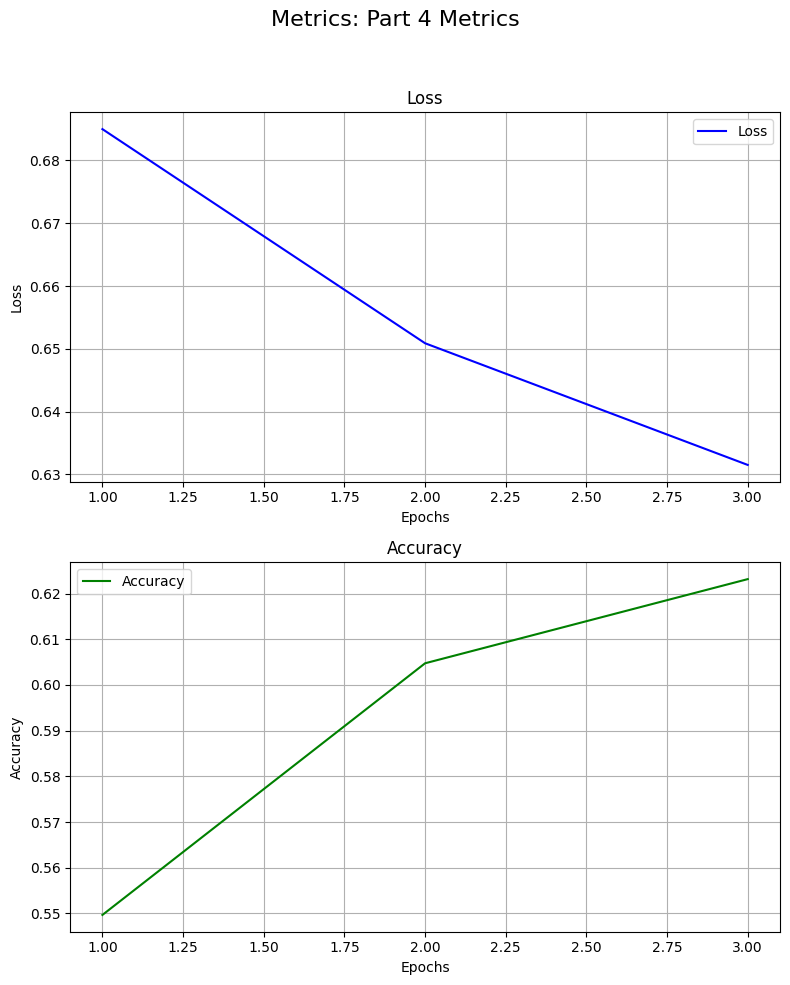

Accuracy: 0.5688


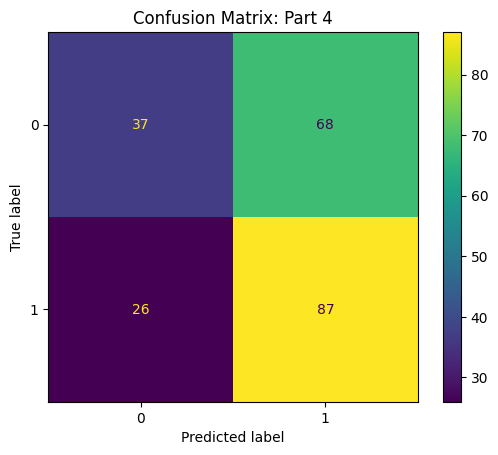

In [10]:
class SentimentClassifier(nn.Module):
    def __init__(self, encoder):
        super(SentimentClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        cls_token_embedding = outputs.last_hidden_state[:, 0, :]  # Use CLS token
        logits = self.classifier(cls_token_embedding)
        return logits


encoder = GPT2Model.from_pretrained('gpt2').to("cuda")
model_4 = SentimentClassifier(encoder).to("cuda")

# Training and evaluation
optimizer = Adam(model_4.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
train_losses_4, train_accuracies_4 = train_model(model_4, train_loader, optimizer, criterion)

# Visualizations
plot_metrics(train_losses_4, train_accuracies_4, "Metrics: Part 4")

y_true_4, y_pred_4 = evaluate_model(model_4, val_loader)
accuracy = accuracy_score(y_true_4, y_pred_4)
print(f"Accuracy: {accuracy:.4f}")
plot_confusion_matrix(y_true_4, y_pred_4, "Confusion Matrix: Part 4")

## Step 5: Add a Linear Layer on Top of the Encoder's Output

Epoch 1/3
Epoch 1/3 | Train Loss: 0.6257, Train Accuracy: 0.6281 | 
Epoch 2/3
Epoch 2/3 | Train Loss: 0.6121, Train Accuracy: 0.6368 | 
Epoch 3/3
Epoch 3/3 | Train Loss: 0.6035, Train Accuracy: 0.6441 | 


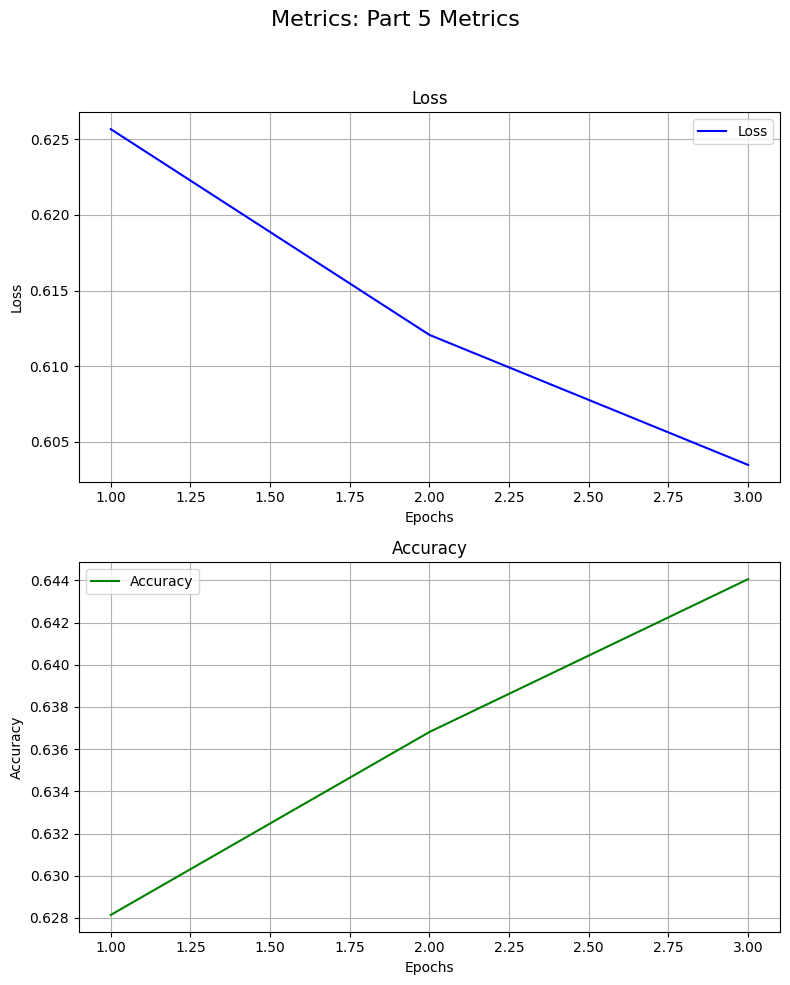

Accuracy: 0.5917


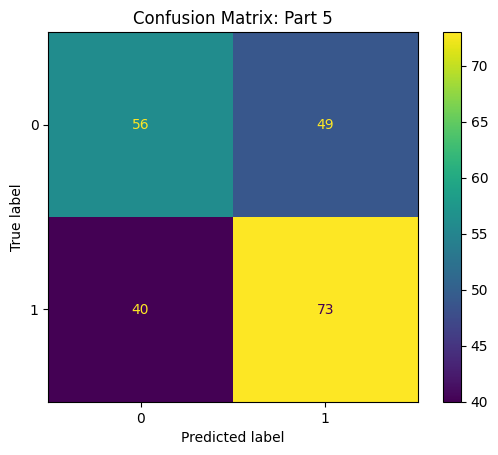

In [11]:
class SentimentClassifierWithLinear(nn.Module):
    def __init__(self, encoder):
        super(SentimentClassifierWithLinear, self).__init__()
        self.encoder = encoder
        self.aggregation_layer = nn.Linear(encoder.config.hidden_size, encoder.config.hidden_size)
        self.classifier = nn.Linear(encoder.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        cls_token_embedding = outputs.last_hidden_state[:, 0, :]
        aggregated_output = self.aggregation_layer(cls_token_embedding)
        logits = self.classifier(aggregated_output)
        return logits

model_5 = SentimentClassifierWithLinear(encoder).to("cuda")

# Training and evaluation
optimizer = Adam(model_5.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
train_losses_5, train_accuracies_5 = train_model(model_5, train_loader, optimizer, criterion)
y_true_5, y_pred_5 = evaluate_model(model_5, val_loader)

# Visualizations
plot_metrics(train_losses_5, train_accuracies_5, "Metrics: Part 5")

y_true_5, y_pred_5 = evaluate_model(model_5, val_loader)
accuracy = accuracy_score(y_true_5, y_pred_5)
print(f"Accuracy: {accuracy:.4f}")
plot_confusion_matrix(y_true_5, y_pred_5, "Confusion Matrix: Part 5")


## Step 6: Add Bidirectional Attention Layer

Epoch 1/3
Epoch 1/3 | Train Loss: 0.3517, Train Accuracy: 0.8437 | 
Epoch 2/3
Epoch 2/3 | Train Loss: 0.2083, Train Accuracy: 0.9142 | 
Epoch 3/3
Epoch 3/3 | Train Loss: 0.1359, Train Accuracy: 0.9487 | 


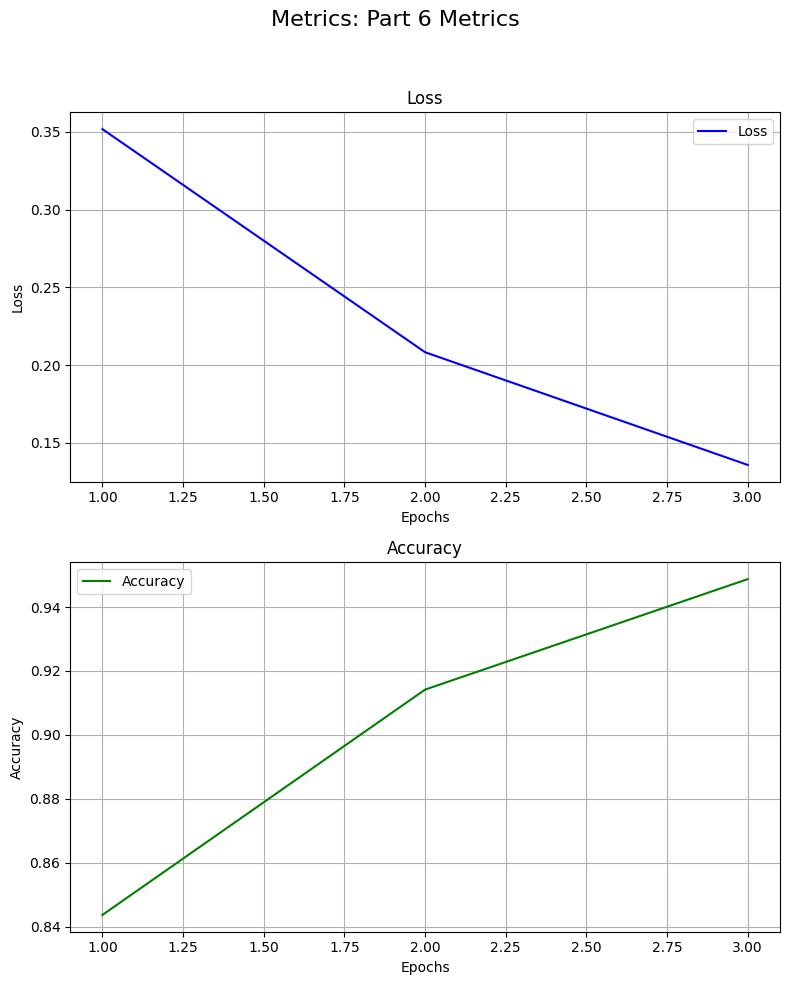

Accuracy: 0.8853


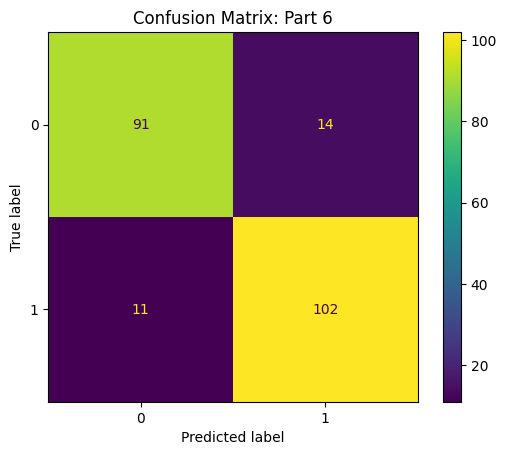

In [12]:
class SentimentClassifierWithAttention(nn.Module):
    def __init__(self, encoder):
        super(SentimentClassifierWithAttention, self).__init__()
        self.encoder = encoder
        self.attention_layer = nn.MultiheadAttention(embed_dim=encoder.config.hidden_size, num_heads=12)
        self.classifier = nn.Linear(encoder.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state.transpose(0, 1)  # Transpose for attention
        attn_output, _ = self.attention_layer(cls_embedding, cls_embedding, cls_embedding)
        logits = self.classifier(attn_output[0])  # Use CLS token
        return logits

model_6 = SentimentClassifierWithAttention(encoder).to("cuda")

# Training and evaluation
optimizer = Adam(model_6.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
train_losses_6, train_accuracies_6 = train_model(model_6, train_loader, optimizer, criterion)
y_true_6, y_pred_6 = evaluate_model(model_6, val_loader)

# Visualizations
plot_metrics(train_losses_6, train_accuracies_6, "Metrics: Part 6")

y_true_6, y_pred_6 = evaluate_model(model_6, val_loader)
accuracy = accuracy_score(y_true_6, y_pred_6)
print(f"Accuracy: {accuracy:.4f}")
plot_confusion_matrix(y_true_6, y_pred_6, "Confusion Matrix: Part 6")


## Step 7: Add Unidirectional Attention (Left-to-Right and Right-to-Left)

Epoch 1/3
Epoch 1/3 | Train Loss: 0.6240, Train Accuracy: 0.6310 | 
Epoch 2/3
Epoch 2/3 | Train Loss: 0.6144, Train Accuracy: 0.6378 | 
Epoch 3/3
Epoch 3/3 | Train Loss: 0.6033, Train Accuracy: 0.6509 | 


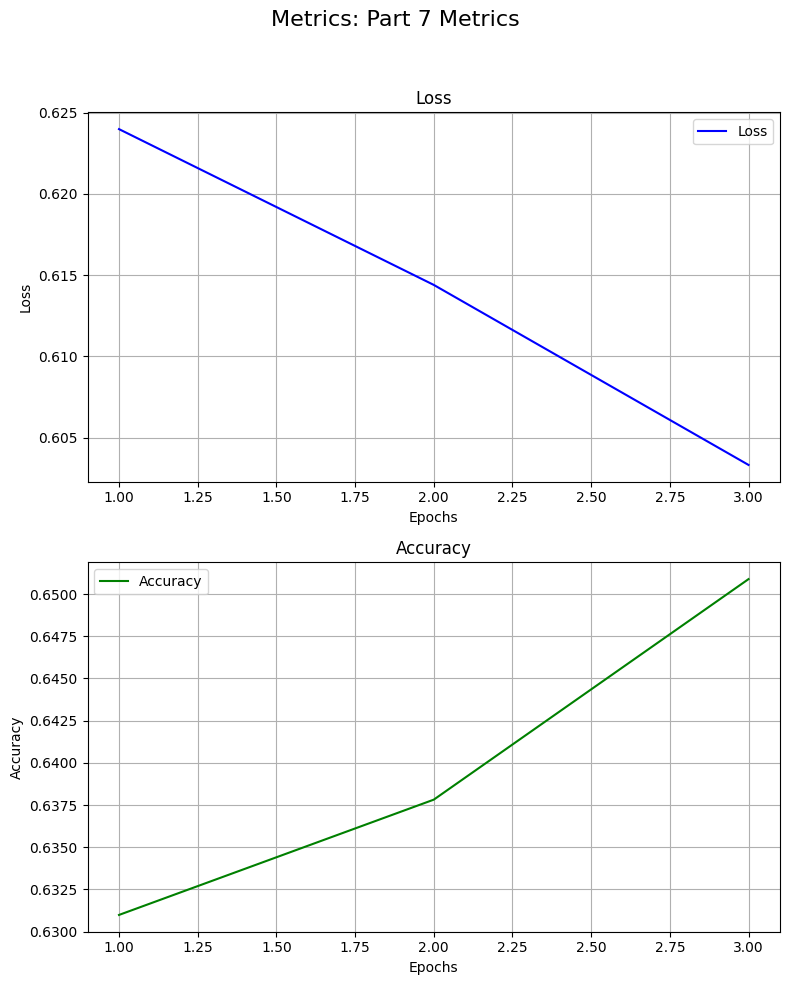

Accuracy: 0.5413


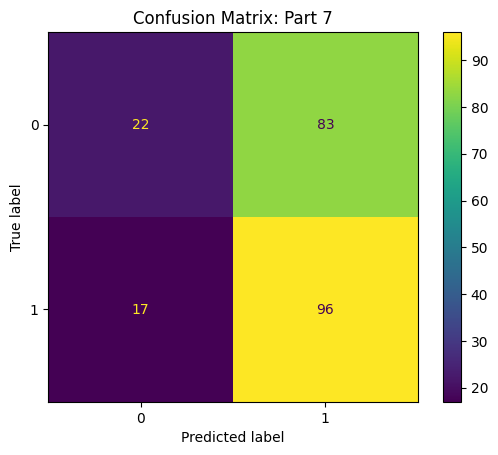

In [14]:
class SentimentClassifierWithUnidirectionalAttention(nn.Module):
    def __init__(self, encoder, direction="left-to-right"):
        super(SentimentClassifierWithUnidirectionalAttention, self).__init__()
        self.encoder = encoder
        self.direction = direction
        self.attention_layer = nn.MultiheadAttention(embed_dim=encoder.config.hidden_size, num_heads=12)
        self.classifier = nn.Linear(encoder.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state.transpose(0, 1)  # Transpose for multihead attention
        if self.direction == "left-to-right":
            attn_mask = torch.triu(torch.ones(cls_embedding.size(0), cls_embedding.size(0)), diagonal=1).bool()
        else:
            attn_mask = torch.tril(torch.ones(cls_embedding.size(0), cls_embedding.size(0)), diagonal=-1).bool()
        attn_output, _ = self.attention_layer(cls_embedding, cls_embedding, cls_embedding, attn_mask=attn_mask.to("cuda"))
        logits = self.classifier(attn_output[0])  # CLS token representation
        return logits
        
model_7 = SentimentClassifierWithUnidirectionalAttention(encoder, direction="left-to-right").to("cuda")

optimizer = Adam(model_7.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

train_losses_7, train_accuracies_7 = train_model(model_7, train_loader, optimizer, criterion)

y_true_7, y_pred_7 = evaluate_model(model_7, val_loader)

plot_metrics(train_losses_7, train_accuracies_7, "Metrics: Part 7")

accuracy = accuracy_score(y_true_7, y_pred_7)
print(f"Accuracy: {accuracy:.4f}")

plot_confusion_matrix(y_true_7, y_pred_7, "Confusion Matrix: Part 7")


## Step 8: Load BERT and Evaluate Zero-shot Performance

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Zero-shot Accuracy: 0.5275


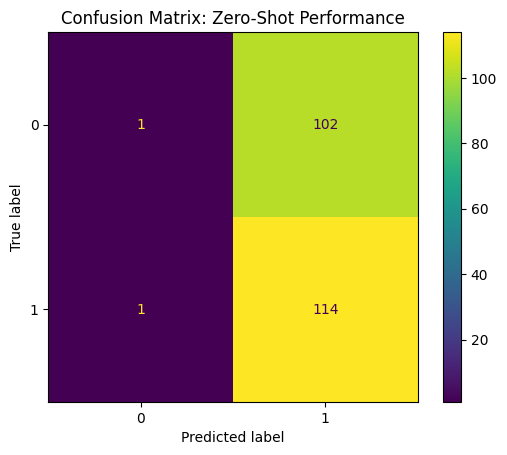

In [25]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to("cuda")

dataset = load_dataset('glue', 'sst2')
# Create subsets
train_subset = create_subset(dataset['train'], fraction=fraction)
val_subset = create_subset(dataset['validation'], fraction=fraction)
test_subset = create_subset(dataset['test'], fraction=fraction)

# DataLoaders for the subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

def evaluate_zero_shot(model, tokenizer, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_texts = batch['sentence']
            labels = batch['label'].to("cuda")
            inputs = tokenizer(input_texts, padding=True, truncation=True, return_tensors="pt").to("cuda")
            
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

y_true_8, y_pred_8 = evaluate_zero_shot(model_bert, tokenizer_bert, val_loader)

accuracy = accuracy_score(y_true_8, y_pred_8)
print(f"Zero-shot Accuracy: {accuracy:.4f}")

plot_confusion_matrix(y_true_8, y_pred_8, "Confusion Matrix: Zero-Shot Performance")

---------
### References

[1] Raffel, Colin, Noam Shazeer, Adam Roberts, et al. (2020). *Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer*. [Link to paper](https://arxiv.org/abs/1910.10683)

[2] Touvron, Hugo, et al. (2023). *LLaMA 2: Open Foundation and Fine-Tuned Chat Models*. [Link to paper](https://arxiv.org/abs/2307.09288)

<span style="color:yellow;">*For further reading on this field of research, you can refer to the following papers:*</span>

[3] BehnamGhader, Adlakha, et al. (2024). *LLM2Vec: Large Language Models Are Secretly Powerful Text Encoders*. [Link to paper](https://arxiv.org/abs/2404.05961)

[4] Gao, Tianyu, et al. (2021). *SimCSE: Simple Contrastive Learning of Sentence Embeddings*. [Link to paper](https://arxiv.org/abs/2104.08821)

[5] Lee, et al. (2023). *NV-Embed: Improved Techniques for Training LLMs as Generalist Embedding Models*. [Link to paper](https://arxiv.org/abs/2405.17428)




# **Best regards.**